In [1]:
%pylab inline

import numpy as np
import pandas as pd

from dataset import load_wiki_traffic_dataset
from itertools import combinations
from sklearn.linear_model import Lasso

from pprint import pprint as pp
from IPython.display import display

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


# Dataset

[Kaggle Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data) 에서 다운로드 받을 수 있습니다.

Training dataset은 145,000개의 time series로 구성되어 있으며, 각각의 time series들은  2015년 7월 1일부터 2016년 12월 31일까지의  서로다른 위키피디아 문서의 daily view의 횟수를 나탄냅니다.<br>


# Configuration

In [2]:
TRAIN_PATH = '/dataset/web-traffic-forecast/train_1.csv'
TEST_PATH = '/dataset/web-traffic-forecast/key_1.csv'

# Data Exploration

## Load Dataset

In [3]:
train_dataset, test_dataset = load_wiki_traffic_dataset(TRAIN_PATH, TEST_PATH)
sample_train = train_dataset.sample(1000)
sample_test = test_dataset.sample(1000)

display(train_dataset.head())
train_dataset.info()
display(test_dataset.head())
test_dataset.info()

,page,country,project,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,wikipedia,all-access,spider,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM,zh,wikipedia,all-access,spider,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C,zh,wikipedia,all-access,spider,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute,zh,wikipedia,all-access,spider,35.0,13.0,10.0,94.0,4.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You,zh,wikipedia,all-access,spider,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 555 entries, page to 2016-12-31
dtypes: float64(550), object(5)
memory usage: 614.2+ MB


,name,date,Id
0,!vote_en.wikipedia.org_all-access_all-agents,2017-01-01,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents,2017-01-02,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents,2017-01-03,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents,2017-01-04,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents,2017-01-05,fa012434263a


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703780 entries, 0 to 8703779
Data columns (total 3 columns):
name    object
date    object
Id      object
dtypes: object(3)
memory usage: 199.2+ MB


## Data Overview

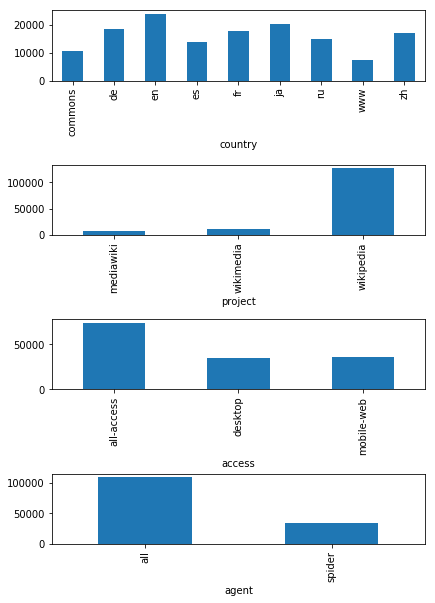

In [4]:
fig, plots = subplots(4)
fig.set_figheight(8)
fig.tight_layout()
fig.subplots_adjust(hspace=1.2)

train_dataset.groupby('country')['country'].count().plot(kind='bar', ax=plots[0])
train_dataset.groupby('project')['project'].count().plot(kind='bar', ax=plots[1])
train_dataset.groupby('access')['access'].count().plot(kind='bar', ax=plots[2])
train_dataset.groupby('agent')['agent'].count().plot(kind='bar', ax=plots[3])

## 데이터에 대한 plot

1. Non-stationary 데이터
2. 0인 부분은 글이 아직 작성되지 않음

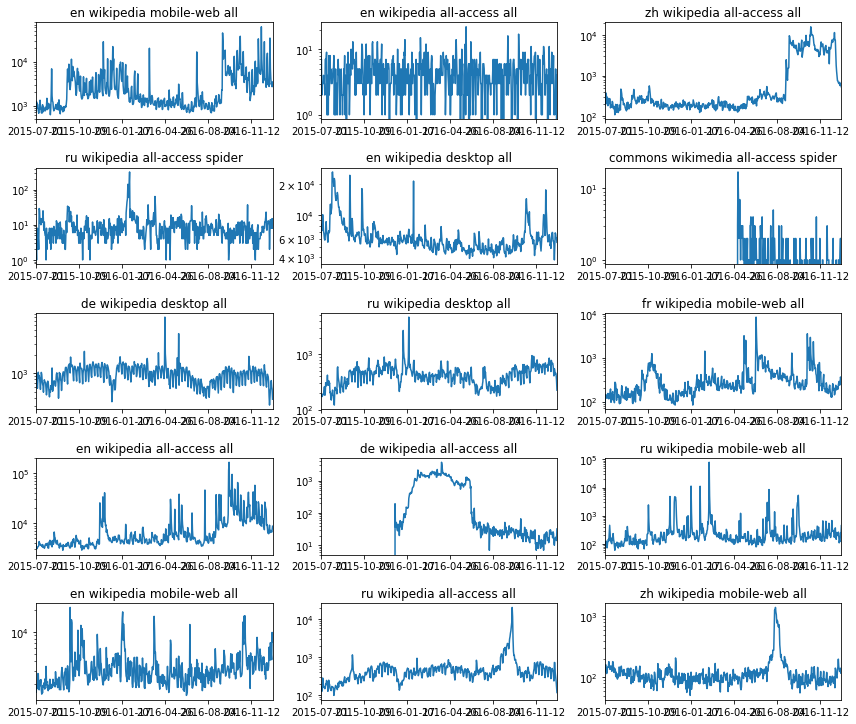

In [5]:
def random_plot(dataset):
    n = dataset.shape[0]
    
    fig, plots = subplots(5, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(10)
    fig.set_figwidth(12)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    
    for p in plots:
        idx = np.random.randint(n)
        row = dataset.iloc[idx]
        title = f"{row['country']} {row['project']} {row['access']} {row['agent']}"
        dataset.iloc[idx, 5:].T.plot(ax=p, logy=True, title=title)
    
random_plot(train_dataset)

## 전체 데이터셋의 트렌드

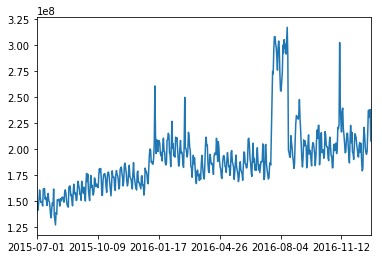

In [6]:
train_dataset.iloc[:, 5:].sum(axis=0).plot()

# 국가별 분석

## 국가별 데이터 히스토그램

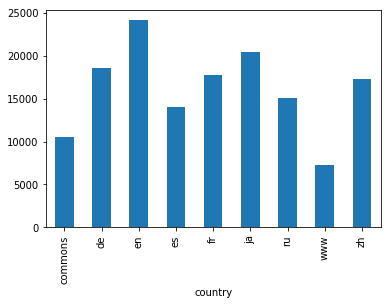

In [4]:
train.groupby('country')['country'].count().plot(kind='bar')

## 국가별 트렌드

country,commons,de,en,es,fr,ja,ru,www,zh
country,,,,,,,,,
commons,1.000000,0.043355,0.374597,0.197975,0.289372,0.306744,0.049741,0.186837,0.438006
de,0.043355,1.000000,0.154222,0.300227,0.586279,0.337375,0.057187,0.060339,0.392841
en,0.374597,0.154222,1.000000,0.101900,0.284672,0.386656,0.799605,0.058430,0.534174
es,0.197975,0.300227,0.101900,1.000000,0.290677,0.013924,0.005300,0.158443,0.113134
fr,0.289372,0.586279,0.284672,0.290677,1.000000,0.476908,0.147278,0.150433,0.588744
ja,0.306744,0.337375,0.386656,0.013924,0.476908,1.000000,0.196398,0.186209,0.684289
ru,0.049741,0.057187,0.799605,0.005300,0.147278,0.196398,1.000000,0.008254,0.273804
www,0.186837,0.060339,0.058430,0.158443,0.150433,0.186209,0.008254,1.000000,0.155146
zh,0.438006,0.392841,0.534174,0.113134,0.588744,0.684289,0.273804,0.155146,1.000000


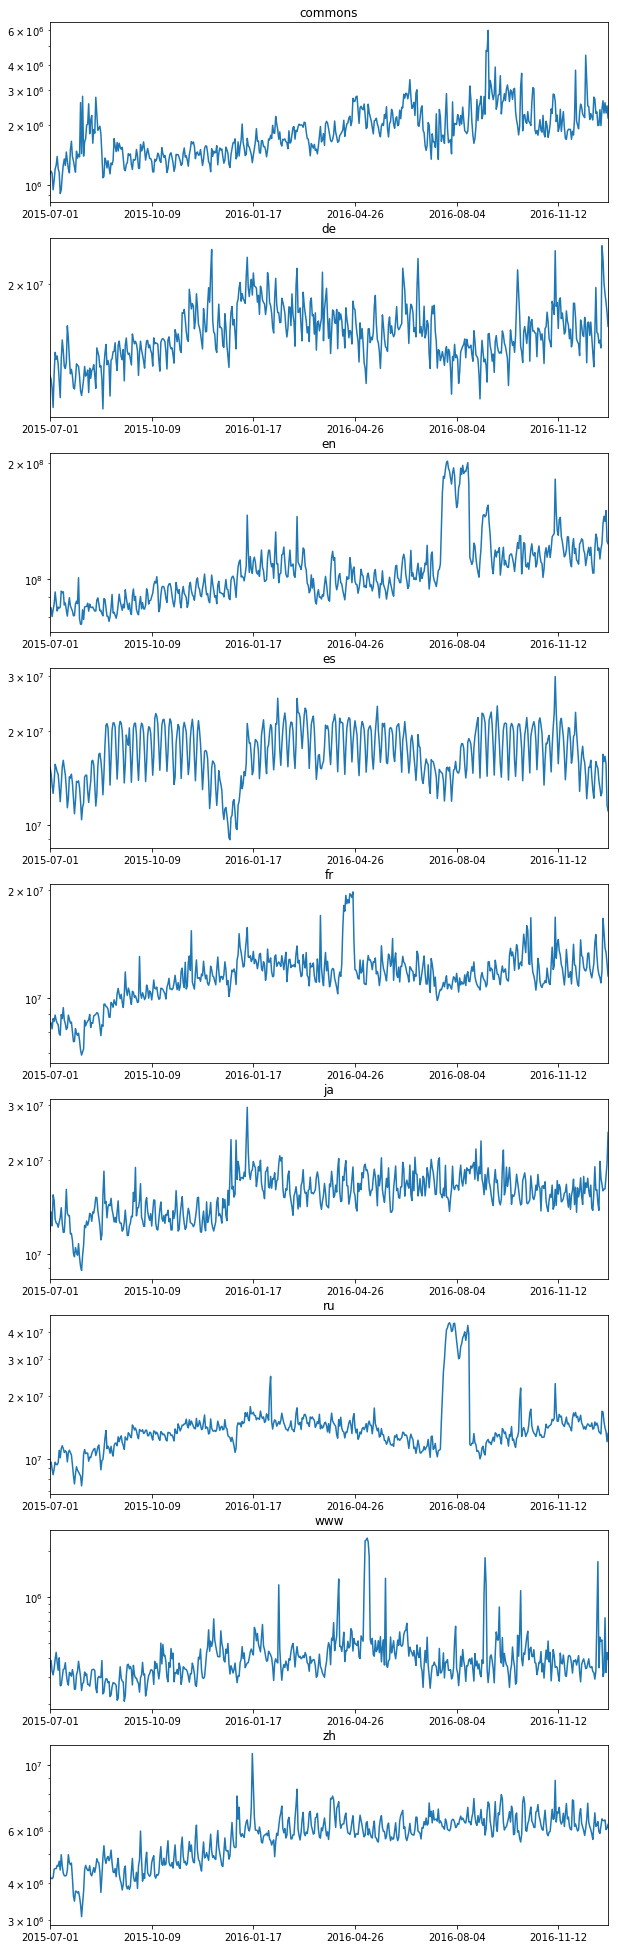

In [8]:
def group(dataset, column_name):
    return dataset.groupby(column_name).sum(axis=1).iloc[:, 4:].T
    
def trend(dataset, height:int, width:int=10):
    fig, plots = subplots(len(dataset.columns), 1)
    fig.set_figheight(height)
    fig.set_figwidth(width)

    for p, c in zip(plots, dataset.columns):
        dataset[c].plot(ax=p, logy=True, label=c)
        p.set_title(c)

countries = group(train_dataset, 'country')
display(countries.corr())
trend(countries, 35)

## 국가별 상관관계및 Scatter Plots

In [36]:
# country_combinations = list(combinations(countries.columns, r=2))
# fig, plots = subplots(len(country_combinations), 1)
# fig.set_figheight(150)

# for p, (c1, c2) in zip(plots, country_combinations):
#     countries.plot.scatter(c1, c2, ax=p)

# Access 분석

access,all-access,desktop,mobile-web
access,,,
all-access,1.000000,0.932431,0.537284
desktop,0.932431,1.000000,0.213871
mobile-web,0.537284,0.213871,1.000000


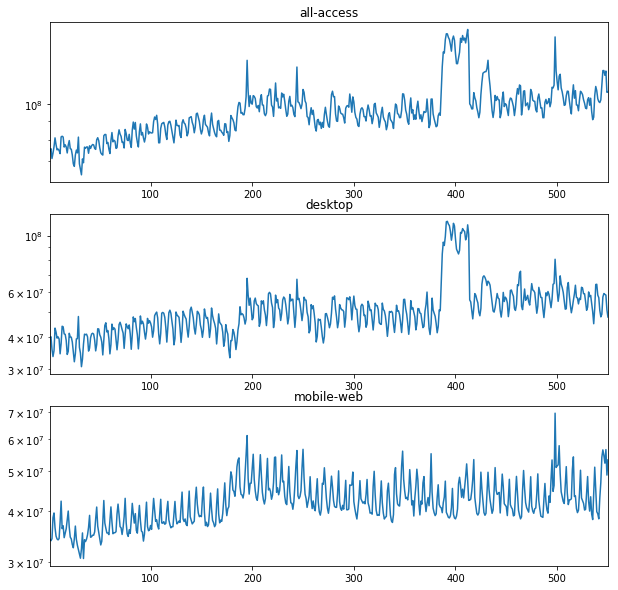

In [39]:
accesses = group(train, 'access')
display(accesses.corr())
trend(accesses, 10)